### **The grid generation** 

The grid generation is one of the most important steps in our experiments, as it defines the granularity of our mixture approximations. There is some literature related to designing optimal grids (http://www.quantize.maths-fi.com/symposium, for instance), however, we will only adopt a few common-sense heuristics.

For the moment, our code is only capable of designing **hypercubic axis-aligned grids** in which the spacing for each axis may be equally or unequally distributed.  

In [2]:
import torch
import matplotlib.pyplot as plt

import grid_generation as grid
from distributions import GaussianMixture

In [3]:
def draw_square(x_min, y_min, x_max, y_max):
    plt.plot([x_min, x_max, x_max, x_min, x_min], [y_min, y_min, y_max, y_max, y_min], color='black', linewidth=0.8)

def plot_regions(regions, signatures, samples):
    # Update font size
    plt.rcParams.update({'font.size': 18})

    # Plot regions (regions should be a PyTorch tensor)
    for region in regions:
        x_min, y_min = region[0]
        x_max, y_max = region[1]
        draw_square(x_min.item(), y_min.item(), x_max.item(), y_max.item())  # Convert to standard Python types for plotting

    # Plot signatures (convert to numpy for plotting)
    plt.scatter(signatures[:, 0].numpy(), signatures[:, 1].numpy(), color='black', label='Signatures', s=7)

    # Plot samples using 2D histogram (convert to numpy)
    plt.hist2d(samples[:, 0].numpy(), samples[:, 1].numpy(), bins=500, alpha=0.3, cmap='coolwarm', cmin=0.1)

    # Set plot limits
    #plt.xlim(-2, 2)
    #plt.ylim(-2, 2)
    
    # Set labels and turn off the grid
    plt.xlabel('State[0]')
    plt.ylabel('State[1]')
    plt.grid(False)
    
    # Show the plot
    plt.show()

### 1) Adaptative grid

#### 1.1) Build grid method

In [5]:
# Initial distribution parameters
initial_weights = torch.Tensor([0.5, 0.5])
initial_means = torch.Tensor([[8, 10], [6, 10]])
sigma = 0.005
cov = sigma * torch.eye(2)
initial_covariances = torch.stack((cov, cov), dim=0)

initial_distribution = GaussianMixture(initial_means, initial_covariances, initial_weights)

In [6]:
n_samples = 1_000
samples = initial_distribution(n_samples)

In [7]:
high_prob_region = grid.identify_high_prob_region(samples)

In [8]:
regions = grid.create_regions(high_prob_region = high_prob_region, 
                              samples = samples, 
                              min_proportion = 0.1, 
                              min_size = 0.2, 
                              max_depth = 5, 
                              current_depth = 0, 
                              grid_type = "adaptive_grid")
signatures = grid.place_signatures(regions)

Number of regions: 34


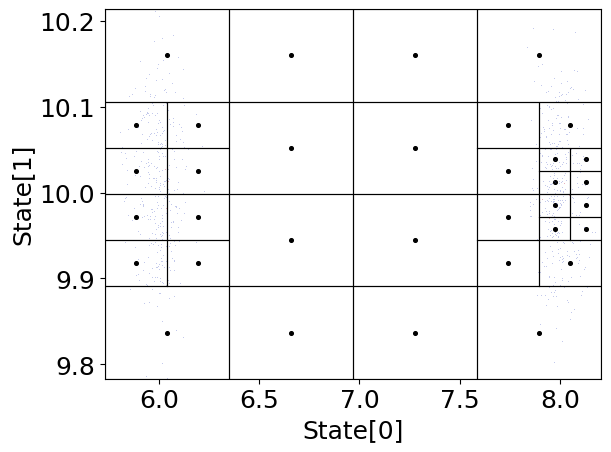

In [9]:
plot_regions(regions, signatures, samples)

#### 1.2) After refinement

We randomly select contributions and refine the regions according to them.

In [11]:
contributions = torch.rand(regions.size(0))

In [12]:
regions, signatures = grid.refine_regions(regions, signatures, contributions, 9e-1)

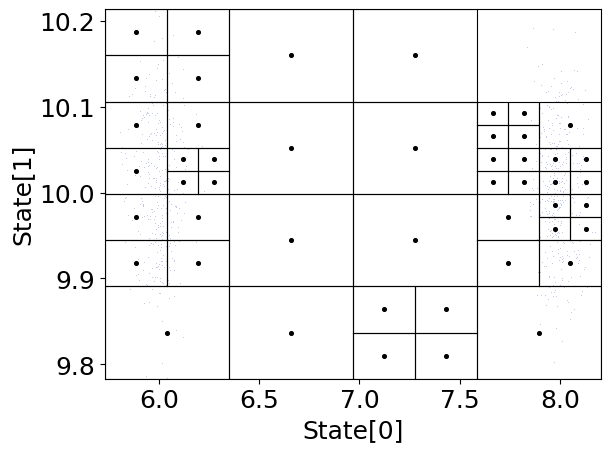

In [13]:
plot_regions(regions, signatures, samples)

### 2) Uniform grid

In [15]:
regions = grid.create_regions(high_prob_region = high_prob_region, 
                              samples = samples, 
                              min_proportion = 0.1, 
                              min_size = 0.2, 
                              max_depth = 2, 
                              current_depth = 0, 
                              grid_type = "uniform_grid")
signatures = grid.place_signatures(regions)

Number of regions: 64


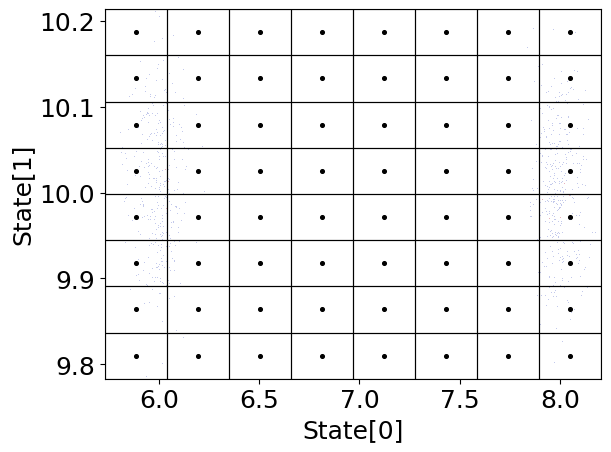

In [16]:
plot_regions(regions, signatures, samples)